In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''Define connections'''

conn_g = [(0,6), (1,6)]
conn_s = [(2,6), (3,6), (4,6), (5,6)]

'''Get inputs'''
import pickle

with open('currents', 'rb') as f:
    sensors, inputs, dt, n_par = pickle.load(f)

print(inputs.shape, dt.shape)

(4126, 4, 6, 1) torch.Size([4, 1, 1])


In [3]:
'''Create circuit'''

import sys
sys.path.insert(0, '..')
from odynn.circuit import Circuit
from odynn.models import LeakyIntegrate, ChemSyn, GapJunction
import numpy as np
import torch

DT = dt

def get_circ(N_parallel = 50):
    pout = LeakyIntegrate.get_random(1, N_parallel)
    pn = {k: np.concatenate((n_par[k].repeat(6, N_parallel).detach(), pout[k]), 0) for k,v in pout.items()}
    n = LeakyIntegrate(init_p=pn, tensors=True, dt=DT)
    ps = ChemSyn.get_random(len(conn_s),N_parallel)
    ps['E'] = np.repeat([[-1],[0],[0],[1]], N_parallel, axis=-1) + np.random.rand(4,N_parallel) * 0.2
    s = ChemSyn([c[0] for c in conn_s], [c[1] for c in conn_s], 
                              init_p=ps, tensors=True, dt=DT)
    pg = GapJunction.get_random(len(conn_g),N_parallel)
    g = GapJunction([c[0] for c in conn_g], [c[1] for c in conn_g], 
                              init_p=pg, tensors=True, dt=DT)
    return Circuit(n, s, g)


get_circ().plot(labels={i: n for i,n in enumerate(['AVBL', 'AVBR', 'VA12', 'PVCR', 'PVCL', 'DVA', 'DB07'])})

<Figure size 1000x1000 with 1 Axes>

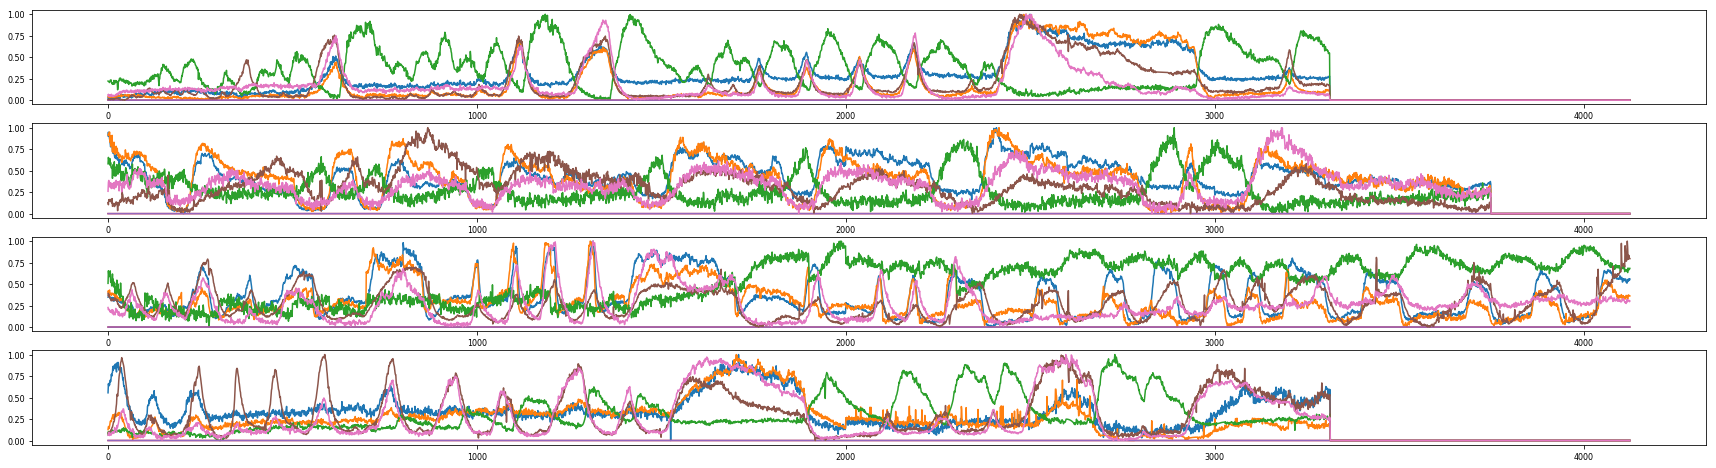

torch.Size([4126, 1, 4, 7, 1]) torch.Size([4126, 1, 4, 7, 1])


In [4]:
'''Get ground truth'''

import pylab as plt
import data
from odynn import optim

NEURS = ['AVBL', 'AVBR', 'VA12', 'PVCR', 'PVCL', 'DVA', 'DB07']
N_sets = 4

inputs = inputs#[:3300]
plt.figure(figsize=(30,8))
traces_orig = np.zeros((inputs.shape[0], N_sets, len(NEURS)))

for i,j in enumerate([0,1,2,4]):
    allt = data.get_data(j)
    allt['PVCR'] = np.zeros(allt.shape[0])
    allt['PVCL'] = np.zeros(allt.shape[0])
    traces_orig[:allt.shape[0],i] = allt[NEURS]
    dt[i] = 4000 / allt.shape[0]
    # sns.heatmap(traces.corr(), cmap='bwr', vmin=-1, vmax=1, annot=True)
    plt.subplot(N_sets,1,i+1)
    plt.plot(traces_orig[:,i])
    
# for i,j in enumerate([0,1,2,4]):
#     allt = data.get_data(j).iloc[:3300]
# #     print(allt.shape)
#     print(allt.shape)
#     print(traces_orig.shape)
#     allt['PVCR'] = np.zeros(allt.shape[0])
#     allt['PVCL'] = np.zeros(allt.shape[0])
#     traces_orig[:allt.shape[0],i] = allt[NEURS]
#     dt[i] = 4000 / allt.shape[0]
#     # sns.heatmap(traces.corr(), cmap='bwr', vmin=-1, vmax=1, annot=True)
#     plt.subplot(N_sets,1,i+1)
#     plt.plot(traces_orig[:,i])

plt.show()

traces = torch.Tensor(traces_orig[:,None,:,:,None])
target = traces
print(traces.shape, target.shape)

(4126, 4, 7, 1)


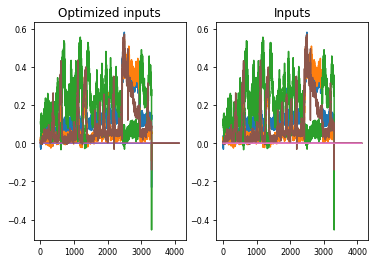

(4126, 4, 7, 1)


In [5]:
'''Get input currents'''

    
plt.subplot(121)
plt.plot(inputs[:,0,:,0])
plt.title('Optimized inputs')

# FLOAT !!!!!!!!!!!!!
inj = np.full((traces.shape[0], traces.shape[2], traces.shape[3], 1), 0.)
print(inj.shape)

sensors_idx = []
for i, n in enumerate(sensors):
    idx = list(NEURS).index(n)
    sensors_idx.append(idx)
    inj[:,:,idx] = inputs[:,:,i]
    
    
plt.subplot(122)
plt.title('Inputs')
plt.plot(inj[:, 0, :, 0])
plt.show()

# add few timesteps at beginning for stability
# injstab = np.zeros(inj.shape)
# injstab = injstab[:20]
# inj = np.concatenate((injstab, inj))
print(inj.shape)

  0%|          | 0/701 [00:00<?, ?it/s]

torch.Size([1, 4, 7, 1]) (4126, 4, 7, 1) torch.Size([1, 1, 7, 1]) torch.Size([4126, 1, 4, 7, 1])
Initial states shape :  torch.Size([1, 4, 7, 1]) Input current shape :  torch.Size([4126])
612.8447 379.27713


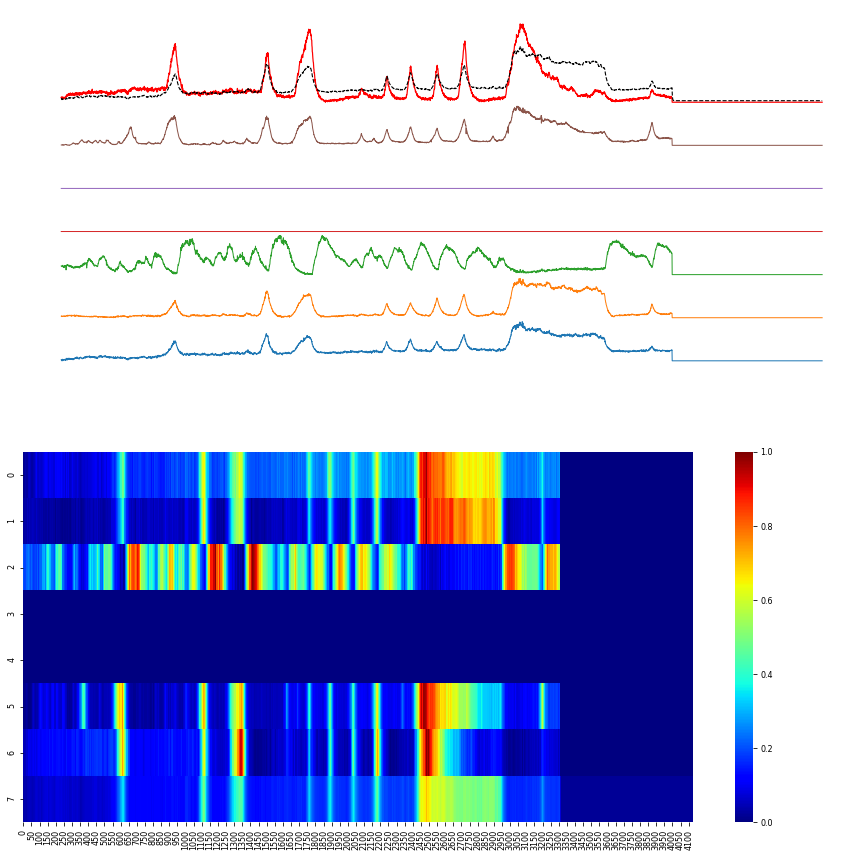

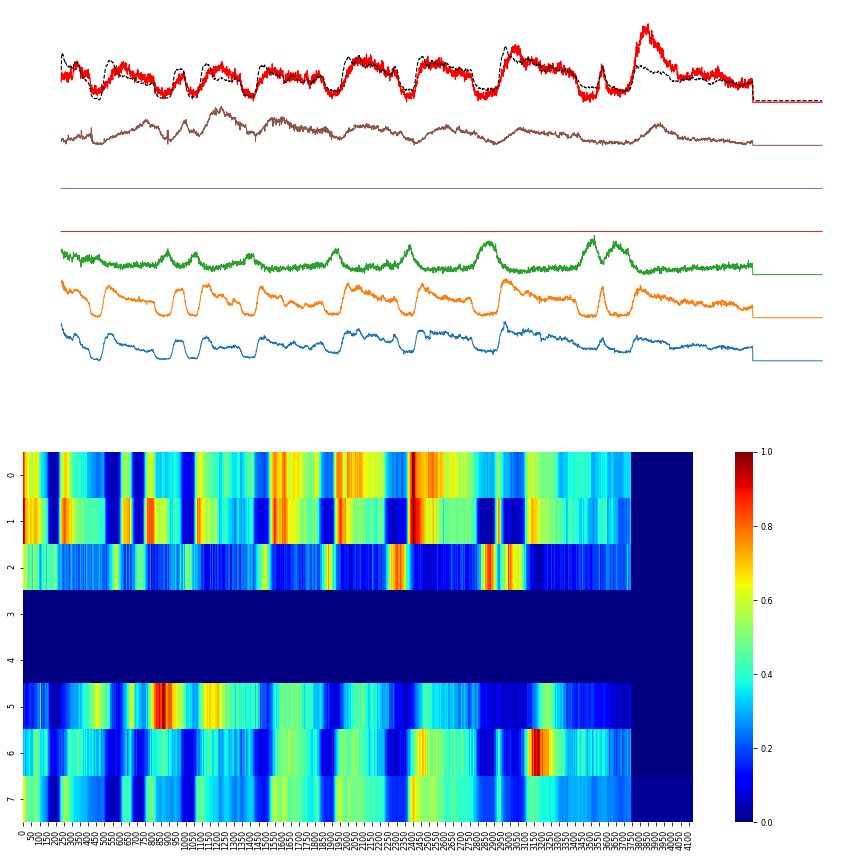

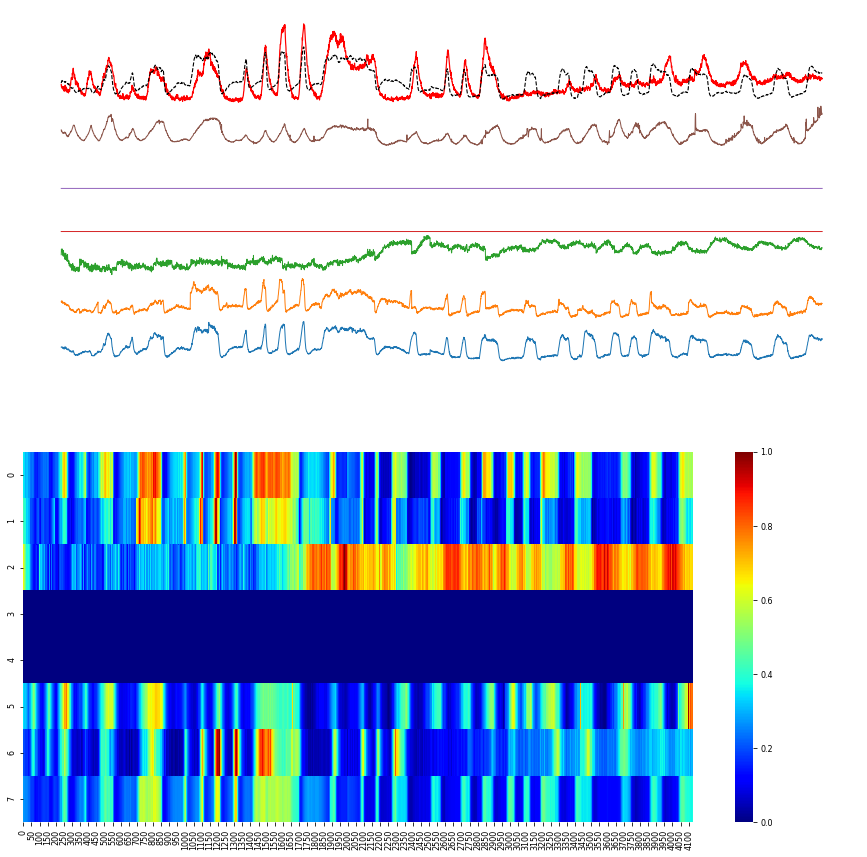

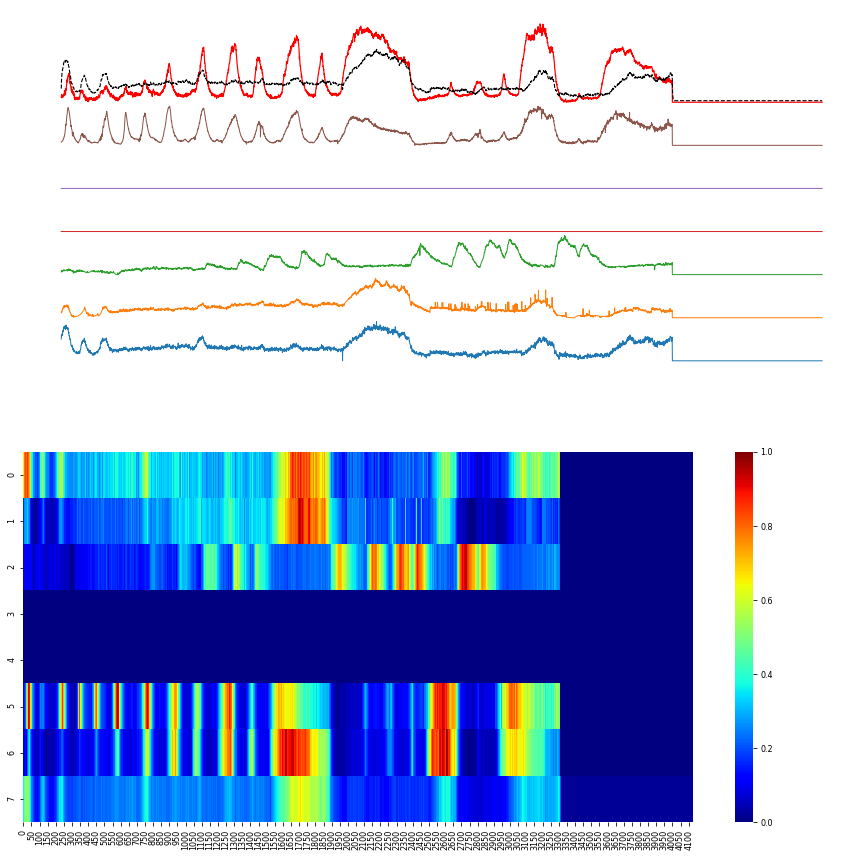

  0%|          | 1/701 [00:21<4:11:12, 21.53s/it]

Initial states shape :  torch.Size([1, 4, 7, 1]) Input current shape :  torch.Size([4126])


KeyboardInterrupt: 

In [6]:
from tqdm import tqdm
import seaborn as sns
import pickle
import psutil


init = traces[0]
i_inj = inj
vmask = torch.zeros((1,1,traces.shape[-2],1))
vmask[:,:,-1] = 1
vadd = traces.clone()
vadd[:,:,:,-1] = 0
print(init.shape, inj.shape, vmask.shape, traces.shape)

"""Optimize out neuron"""
N_P = 500
circuit = get_circ(N_P)

def load_param(name='paramsd07.2'):
    with open(name, 'rb') as f:
        p = pickle.load(f)
    for sub in [circuit._neurons, circuit._synapses, circuit._gaps]:
        for n in sub._parameter_names:
            sub._param[n] = torch.Tensor(p[n])
            sub._param[n].requires_grad = True
# load_param()

ALIGN = [1.1*n for n in range(target.shape[-2])]
def plots(y, traces, loss):
    for i in range(N_sets):
        plt.figure(figsize=(15,15))
        best = loss.argmin()
        plt.subplot(211)
        plt.plot(target[:,0,i,:-1,0].detach().numpy() + ALIGN[:-1], linewidth=1)
        plt.plot(2*target[:,0,i,-1,0].detach().numpy() + ALIGN[-1], linewidth=1.2, color='r')
#         plt.axvline(20, color='k', linestyle='--')
        plt.plot(2*y[:,0,i,-1,best].detach().numpy() + ALIGN[-1], linewidth=1.1, linestyle='--', color='k')
#         plt.subplot(222)
#         plt.plot(traces[:,0,i,:,0].detach().numpy(), linewidth=1)
        plt.axis('off')
        plt.subplot(212)
        best_cat = torch.cat( (traces[:,0,i,:,0],y[:,0,i,-1:,best]), dim=1 ).detach().numpy().T
        sns.heatmap(best_cat, cmap='jet', vmin=0, vmax=1)
#         plt.subplot(224)
#         sns.heatmap(traces[:,0,i,:,0].detach().numpy().T, cmap='jet', vmin=0, vmax=1)
        plt.show()
        plt.close()
    
losses = []
params = [v for v in circuit.parameters.values()]
optimizer = torch.optim.Adam(params, lr=0.001)

func = lambda x : optim.loss_mse(x, target)
# targetcor = optim.corr(traces)
# func = lambda x : optim.loss_correlation(x, targetcor)

for t in tqdm(range(701)):
#     print('Memory before sim', psutil.virtual_memory())
    y = circuit.calculate(torch.zeros(traces.shape[0]), init, vmask=vmask, vadd=vadd)
#     print('Memory after sim', psutil.virtual_memory())

    loss = func(y)

    losses.append(loss.detach().numpy())
    # Upgrade variables
    optimizer.zero_grad()
    loss.mean().backward()
    for v in circuit._neurons.parameters.values():
        v.grad.data[:-1].zero_()
        
    optimizer.step()

    circuit.apply_constraints()
    
    print(loss.mean().detach().numpy(), loss.min().detach().numpy())

    if t%10 == 0:
        plots(y, target, loss)
        if loss.min() <= losses[-1].min():
            with open('params', 'wb') as f:
                p = {k: v.detach().numpy() for k,v in circuit.parameters.items()}
                pickle.dump(p, f)
                
        

plt.plot([l for l in losses], linewidth=0.2)
plt.yscale('log')
plt.show()

In [7]:
def get_best():
    return losses[-1].min()
best = get_best()

bests100 = []
for n in range(N_P):
    if losses[-1][n] < best + 100:
        bests100.append(n)
        
def paraam(i):
    print(circuit.parameters['G'][:,i].detach())
    print('mdp', circuit.parameters['mdp'][:,i].detach())
    print('E', circuit.parameters['E'][:,i].detach())
    
paraam(bests100)

tensor([[0.0676, 0.2348, 0.1776, 0.1910, 0.1068, 0.2393, 0.2386, 0.0978, 0.0152,
         0.1370, 0.0123, 0.1460, 0.2285, 0.0745, 0.0516, 0.1707, 0.0684, 0.2367,
         0.0886, 0.0618, 0.0557, 0.1996, 0.2188, 0.2302, 0.0890, 0.1190, 0.1443,
         0.1570, 0.2314, 0.0166, 0.0627, 0.2231, 0.0493, 0.0901, 0.0390, 0.2397,
         0.0875, 0.1522, 0.1748, 0.0501, 0.1067, 0.0982, 0.1427, 0.1580, 0.0696,
         0.0543, 0.0212, 0.2363, 0.1002, 0.0318, 0.0365, 0.1801, 0.1284, 0.1959,
         0.1687, 0.1466, 0.0152, 0.1954, 0.1011, 0.0900, 0.1159, 0.1174, 0.0406,
         0.2054, 0.2398, 0.0951, 0.0189, 0.0318, 0.1751, 0.1110, 0.0705, 0.1682,
         0.0711, 0.1750, 0.2336, 0.2160, 0.1551, 0.1276, 0.1923, 0.1053, 0.1110,
         0.0766, 0.1249, 0.2169, 0.2456, 0.1750, 0.2474, 0.1892, 0.2035, 0.0123,
         0.0248, 0.1341, 0.1085, 0.1767, 0.1612, 0.0661, 0.1935, 0.2228, 0.1626,
         0.2284, 0.2184, 0.1601, 0.1963, 0.1351, 0.0768, 0.0643, 0.0765, 0.1779,
         0.1676, 0.0568, 0.2

/home/marc/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
/home/marc/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/marc/.local/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/marc/.local/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/marc/.local/lib/python3.6/site-packages/matplotlib/contour.py:1203: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/home/marc/.local/lib/python3.6/site-packages/matplotlib/contour.py:1205: RuntimeWarning: invalid value encountered in greater
  over = np.nonze

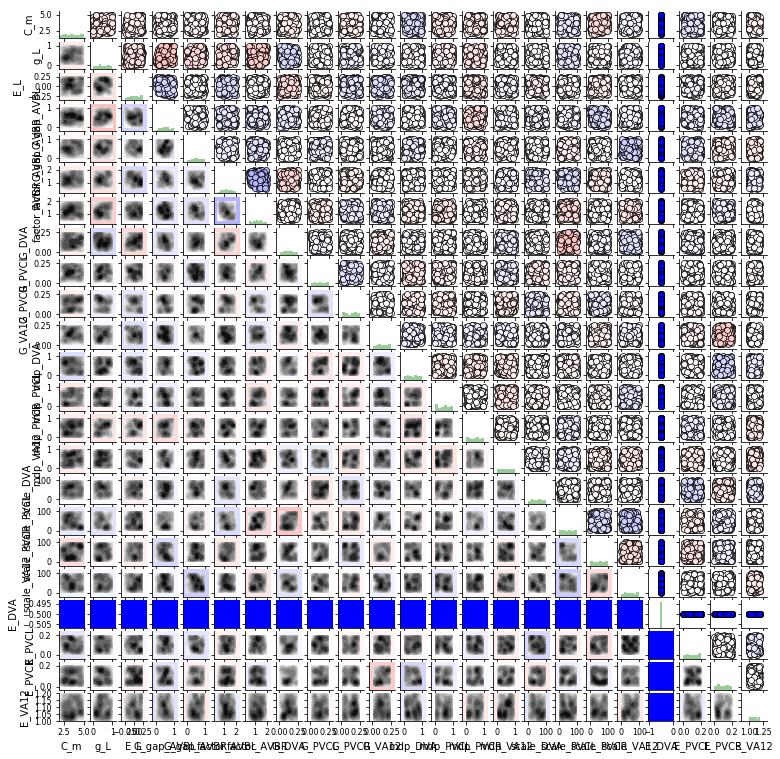

In [8]:
import pandas as pd
import seaborn as sns

def get_par(par):
    return circuit.parameters[par][:,bests100].detach().numpy()

NEURS_SYN = ['DVA', 'PVCL', 'PVCR', 'VA12']
NEURS_GAP = ['AVBL', 'AVBR']
neur_p = np.concatenate([get_par(p)[-1:] for p in circuit._neurons.parameter_names])
neur_c = [p for p in circuit._neurons.parameter_names]

gap_p = np.concatenate([get_par(p) for p in circuit._gaps.parameter_names])
gap_c = ['%s_%s' % (p, n) for p in circuit._gaps.parameter_names for n in NEURS_GAP]

syn_p = np.concatenate([get_par(p) for p in circuit._synapses.parameter_names])
syn_c = ['%s_%s' % (p, n) for p in circuit._synapses.parameter_names for n in NEURS_SYN]

res = pd.DataFrame(np.concatenate((neur_p, gap_p, syn_p)).T, columns=neur_c+gap_c+syn_c)

from scipy import stats
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.bwr
norm = Normalize(vmin=-1, vmax=1)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.set_facecolor(cmap(norm(r)))
    
def corrscat(x ,y, **kws):
    r, _ = stats.pearsonr(x, y)
    plt.scatter(x, y, color=cmap(norm(r)), linewidths=0.7, edgecolors='k')

g = sns.PairGrid(res)
g.fig.set_size_inches(10,10)
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cut=0, cmap='Greys', shade=True)
g.map_upper(corrscat)
g.map_diag(sns.distplot, kde=False, color='g')
plt.savefig('yololo.png')
plt.show()

In [ ]:
from bokeh.layouts import gridplot
from bokeh.plotting import reset_output

reset_output()
output_file('scatter.html')

def scatter_matrix(dataset):
    dataset_source = ColumnDataSource(data=dataset)
    scatter_plots = []
    y_max = len(dataset.columns)-1
    for i, y_col in enumerate(dataset.columns):
        for j, x_col in enumerate(dataset.columns):
            p = figure(plot_width=60, plot_height=60, x_axis_label=x_col, y_axis_label=y_col)
            if j > i:
                p.circle(source=dataset_source,x=x_col, y=y_col, fill_alpha=0.3, line_alpha=0.3, size=3)
            elif i==j:
                p.Histogram(source=dataset_source,x=x_col)
            if j > 0:
                p.yaxis.axis_label = ""
                p.yaxis.visible = False
                p.y_range = linked_y_range
            else:
                linked_y_range = p.y_range
                p.plot_width=160
            if i < y_max:
                p.xaxis.axis_label = ""
                p.xaxis.visible = False
            else:
                p.plot_height=140
            if i > 0:
                p.x_range = scatter_plots[j].x_range

            scatter_plots.append(p)

    grid = gridplot(scatter_plots, ncols = len(dataset.columns))
    show(grid)
    
scatter_matrix(res)

In [ ]:
best = losses[-1].min()

def plot_res():
    for n in range(N_P):
        if losses[-1][n] < best + 1000:
            print(n)
            for i in range(1):
                plt.figure(figsize=(15,2))
        #         plt.plot(traces[:,0,0,:-1,0].detach().numpy() + ALIGN[:-1], linewidth=1)
                plt.plot(2*traces[:,0,i,-1,0].detach().numpy() + ALIGN[-1], linewidth=1.2, color='r')
        #         plt.axvline(20, color='k', linestyle='--')
                plt.plot(2*y[:,0,i,-1,n].detach().numpy() + ALIGN[-1], linewidth=1.1, color='k')
        #         plt.subplot(222)
        #         plt.plot(traces[:,0,i,:,0].detach().numpy(), linewidth=1)
                plt.axis('off')
                plt.show()
                plt.close()
plot_res()